# Case Study 1

In [7]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# show all columns
pd.set_option('display.max_columns', None) 

#Set the seaborn plotting style
sns.set(style="darkgrid")

#set variables for font sizes for plots. This will allow them to be consistent within the notebook
titleFont = 25
axisFont = 15
labelFont = 15

In [8]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('offline.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df = pd.DataFrame(instances, columns = column_names)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181628 entries, 0 to 1181627
Data columns (total 10 columns):
time           1181628 non-null object
scanMac        1181628 non-null object
posX           1181628 non-null object
posY           1181628 non-null object
posZ           1181628 non-null object
orientation    1181628 non-null object
mac            1181628 non-null object
signal         1181628 non-null object
channel        1181628 non-null object
type           1181628 non-null object
dtypes: object(10)
memory usage: 90.2+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3


In [9]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('online.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df_online = pd.DataFrame(instances, columns = column_names)

print(df_online.info())
df_online.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53303 entries, 0 to 53302
Data columns (total 10 columns):
time           53303 non-null object
scanMac        53303 non-null object
posX           53303 non-null object
posY           53303 non-null object
posZ           53303 non-null object
orientation    53303 non-null object
mac            53303 non-null object
signal         53303 non-null object
channel        53303 non-null object
type           53303 non-null object
dtypes: object(10)
memory usage: 4.1+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8a,-43,2437000000,3
1,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:0f:a3:39:e1:c0,-52,2462000000,3
2,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:3b:c7:c6,-62,2432000000,3
3,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:81,-58,2422000000,3
4,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8d,-62,2442000000,3


# EDA

In [10]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
02:64:fb:68:52:e6     50852
00:0f:a3:39:e0:4b     43508
02:2e:58:22:f1:ac     25112
00:0f:a3:39:e2:10     19162
02:37:fd:3b:54:b5      8732
02:b7:00:bb:a9:35      7602
02:5c:e0:50:49:de      6997
00:04:0e:5c:23:fc       418
00:30:bd:f8:7f:c5       301
00:e0:63:82:8b:a9       103
02:0a:3d:06:94:88         1
02:4f:99:43:30:cd         1
02:42:1c:4e:b5:c0         1
Name: mac, dtype: int64

In [11]:
# Drop MAC Ids that have a large abundance of nulls
rows_to_drop = ['02:64:fb:68:52:e6','00:0f:a3:39:e0:4b','02:2e:58:22:f1:ac','00:0f:a3:39:e2:10','02:37:fd:3b:54:b5','02:b7:00:bb:a9:35','02:5c:e0:50:49:de','00:04:0e:5c:23:fc','00:30:bd:f8:7f:c5','00:e0:63:82:8b:a9','02:42:1c:4e:b5:c0','02:0a:3d:06:94:88','02:4f:99:43:30:cd']

df = df[~df['mac'].str.contains('|'.join(rows_to_drop))]

In [12]:
# Drop additional rows with nulls
df = df.dropna()

In [13]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
Name: mac, dtype: int64

In [14]:
df

,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
5,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3
6,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,2412000000,3
10,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:00:42:55:31:00,-84,2457000000,1
11,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
12,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-54,2462000000,3


In [15]:
df.describe()

,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
count,1018838,1018838,1018838,1018838,1018838,1018838,1018838,1018838,1018838,1018838
unique,146074,1,34,14,1,203,8,73,8,2
top,1140377486987,00:02:2D:21:0F:33,2.0,3.0,0.0,90.3,00:0f:a3:39:e1:c0,-59,2462000000,3
freq,15,1018838,85694,209699,1018838,22712,145862,39157,145862,914951


#### Here we one-hot encode the categorical columns enable KNN to process the data and perform clustering

## Including MAC IDs ending CD (and all others but excluding C0)

Weighted KNN appears to produce a better prediction against the test/train split OFFLINE data at .95 compared to .92 using the accuracy score and a k of 5.

In [16]:
# Exclude C0 from DF
df = df[df['mac'] != '00:0f:a3:39:e1:c0']

In [17]:
print(df['mac'].str[15:17])

0          8a
1          90
3          8d
4          81
5          c6
6          cd
10         00
11         8a
13         90
14         c6
15         81
16         8d
18         cd
20         00
21         8a
23         90
24         81
25         c6
26         8d
29         cd
31         8a
32         90
34         81
35         c6
36         8d
37         cd
40         00
42         8a
44         90
45         c6
           ..
1181587    8d
1181588    81
1181589    90
1181590    cd
1181593    8d
1181594    8a
1181595    90
1181596    cd
1181599    c6
1181600    8d
1181601    81
1181602    8a
1181603    cd
1181606    c6
1181607    8d
1181608    8a
1181609    90
1181610    cd
1181611    81
1181613    c6
1181615    8a
1181616    81
1181617    8d
1181618    cd
1181620    c6
1181622    8d
1181623    8a
1181624    81
1181625    90
1181626    cd
Name: mac, Length: 872976, dtype: object


In [18]:
# Sample 20% of rows to decrease run time
df = df.sample(frac=0.20)

In [19]:
df['mac'].value_counts()

00:0f:a3:39:dd:cd    29129
00:14:bf:b1:97:8a    26697
00:14:bf:3b:c7:c6    25152
00:14:bf:b1:97:90    24508
00:14:bf:b1:97:8d    24240
00:14:bf:b1:97:81    24110
02:00:42:55:31:00    20759
Name: mac, dtype: int64

In [20]:
#one hot encoding offline
cols_to_transform = ['mac','scanMac','channel']

df2 = pd.get_dummies(df, columns = cols_to_transform)

In [21]:
df2.dtypes

time                         object
posX                         object
posY                         object
posZ                         object
orientation                  object
signal                       object
type                         object
mac_00:0f:a3:39:dd:cd         uint8
mac_00:14:bf:3b:c7:c6         uint8
mac_00:14:bf:b1:97:81         uint8
mac_00:14:bf:b1:97:8a         uint8
mac_00:14:bf:b1:97:8d         uint8
mac_00:14:bf:b1:97:90         uint8
mac_02:00:42:55:31:00         uint8
scanMac_00:02:2D:21:0F:33     uint8
channel_2412000000            uint8
channel_2422000000            uint8
channel_2427000000            uint8
channel_2432000000            uint8
channel_2437000000            uint8
channel_2442000000            uint8
channel_2457000000            uint8
dtype: object

In [22]:
# Attributes vs. Label split - Offline data
x = df2.iloc[:, :-1].values
y = df2.iloc[:, 4].values

In [23]:
# Split into test / train on the offline data (assuming we cannot even see the online data)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

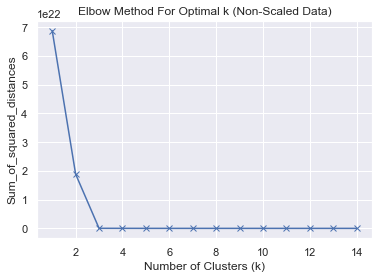

In [24]:
# Create elbow plot for sanity check on number of clusters - unscaled data
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [25]:
# Scale the data - offline
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

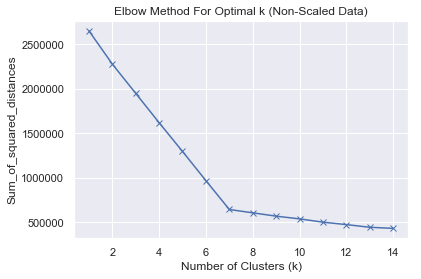

In [26]:
# Create elbow plot for sanity check on number of clusters - scaled data
# Optimal K = 11?
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [27]:
# Create KNN plot - unweighted
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [28]:
y_pred = classifier.predict(X_test)

In [83]:
# Confusion matrix results - avg. precision = .85 / .92  | avg. recall = .85 / .92  |  accuracy = .92
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[365   7   2 ...   0   0   0]
 [  4 397   3 ...   0   0   0]
 [  5   1 357 ...   0   0   0]
 ...
 [  0   0   0 ...  27   0   0]
 [  0   0   0 ...   0  26   0]
 [  0   0   0 ...   0   0  50]]


C:\Users\Owner\New folder\envs\ML7331\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Owner\New folder\envs\ML7331\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       393
         0.1       0.93      0.93      0.93       429
         0.2       0.95      0.94      0.95       378
         0.3       0.95      0.94      0.94       573
         0.4       0.92      0.92      0.92       436
         0.5       0.92      0.96      0.94       297
         0.6       0.96      0.95      0.96       246
         0.7       0.95      0.96      0.96       343
         0.8       0.94      0.95      0.94        94
         0.9       0.80      0.84      0.82        67
         1.0       1.00      0.96      0.98        53
         1.2       0.84      1.00      0.91        42
         1.5       0.89      0.85      0.87       175
       134.2       0.87      0.91      0.89        57
       134.3       0.90      0.85      0.88        55
       134.4       0.82      0.91      0.87        82
       134.5       0.92      0.91      0.91        87
       134.6       0.95    

In [29]:
# Checking the K assumption and plotting all possible K values from 1-40 to see which yields the best mean error rate
error = []

# Calculating error for K values between 1 and 20
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

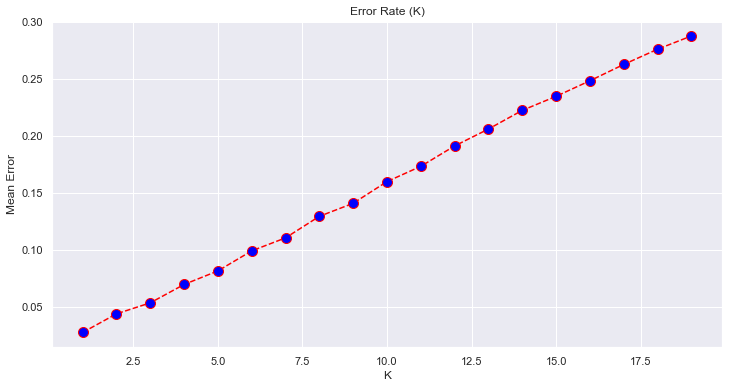

In [30]:
# Plot K

plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate (K)')
plt.xlabel('K')
plt.ylabel('Mean Error')

In [31]:
# Create KNN plot - weighted
classifier = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [32]:
y_pred = classifier.predict(X_test)

In [33]:
# Confusion matrix results - precision .87 / .95  |  accuracy .86 / .95  |  accuracy .95
confusion_matrix(y_test, y_pred)
#print(classification_report(y_test, y_pred))

array([[398,   2,   3, ...,   0,   0,   0],
       [  0, 355,   2, ...,   0,   0,   0],
       [  0,   1, 369, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  26,   0,   0],
       [  0,   0,   0, ...,   0,  26,   0],
       [  0,   0,   0, ...,   0,   0,  52]], dtype=int64)

### What is (are) the drawback(s) (if any of using this method to real-time locate an object)?

- The angles didn't seem like useful data to use in this method because the device will always be held in multiple angles based on the user preference inside the warehouse. Whether the user is holding the device up, down or to the side, the main objective is toidentify the actual location of the device in real time. So as long as we can determine the actual location of the device, the angles are uneccessary.
- The positioning of the actual receivers can also play a part because it is hard to determine if the device is located in multiple floors. Such as being in the 3rd floor because of a mezzanine inside the warehouse compared to being on floor level. It is possible the solution will provide you with the wrong location/distance.

### Describe a method that may be an improvement based on your perceived drawbacks
- Fully utilizing the heat mapping, using the median signal at two access points and two angles. The heat map nicely illustrates representation of signal stength. So you can see how people move around your venue. This allows you to gain important insights on what’s good about your layout.